## Technical test submitted by Ming Li

In [1]:
import polars as pl
import re
import string

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.inspection import permutation_importance, DecisionBoundaryDisplay

from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import shap

In [2]:
plt.style.use("ggplot")

#### Understanding metadata of Mushroom Dataset

In [3]:
with open("data/agaricus-lepiota.names", "r") as f:
    metadata = f.read()
    print(metadata)

1. Title: Mushroom Database

2. Sources: 
    (a) Mushroom records drawn from The Audubon Society Field Guide to North
        American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred
        A. Knopf
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987

3. Past Usage:
    1. Schlimmer,J.S. (1987). Concept Acquisition Through Representational
       Adjustment (Technical Report 87-19).  Doctoral disseration, Department
       of Information and Computer Science, University of California, Irvine.
       --- STAGGER: asymptoted to 95% classification accuracy after reviewing
           1000 instances.
    2. Iba,W., Wogulis,J., & Langley,P. (1988).  Trading off Simplicity
       and Coverage in Incremental Concept Learning. In Proceedings of 
       the 5th International Conference on Machine Learning, 73-79.
       Ann Arbor, Michigan: Morgan Kaufmann.  
       -- approximately the same results with their HILLARY algorithm    
    3. In 

#### mushroom dataset is completely categorical.

- Hypothesis 1: tree-based models may be natively suitable for performing classification task on this type of data, in comparison to other models such as logistic regression, DNN with sigmoid/softmax output layer who mainly work in continuous $\mathbb{R}^k$ feature space.

#### extracting column names from metadata (agaricus-lepiota.names)

In [4]:
text_start = "7. Attribute Information: (classes: edible=e, poisonous=p)"
text_end = "8. Missing Attribute Values"
index_start = metadata.find(text_start)+ len(text_start)
index_end = metadata.find(text_end)
text_extract = metadata[index_start:index_end]

column_pattern = r"\d\. (.*):"
columns_extracted = re.findall(column_pattern, text_extract, flags=re.IGNORECASE)

In [5]:
TARGET_COLUMN = "label"

In [6]:
column_names = [TARGET_COLUMN] + columns_extracted

In [7]:
df_0 = pl.read_csv("data/agaricus-lepiota.data", has_header=False, new_columns=column_names)

In [8]:
print(df_0["label"].value_counts())

shape: (2, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ p     ┆ 3916  │
│ e     ┆ 4208  │
└───────┴───────┘


#### codifying texts to numeric values
- feature space remain discrete irrespective of numeric values assigned
- use a fixed mapping so that when new category is introduced in any feature, existing mapping will not change.

In [9]:
null_mapper = {"?": None, }
label_mapper = {"p": 1, "e": 0}

In [10]:
with pl.StringCache():
    # initiate string cache mapping ascii printable characters to fixed location in cache.
    # so that if any future new data contains new categorical values in features will not change existing codification of dataset.
    charset = string.printable
    s = pl.Series(list(charset)).cast(pl.Categorical)
    reverse_mapping = dict(enumerate(string.printable))
    assert string.printable == ''.join(charset[i] for i in s.to_physical())

    feature_columns = pl.all().exclude(TARGET_COLUMN)
    df_1 = df_0.select(pl.all().replace(null_mapper))
    df_1 = df_1.drop_nulls()

    features_1 = df_1.select(feature_columns) \
        .with_columns(pl.all().cast(pl.Categorical)) \
        .with_columns(pl.all().to_physical())
    label = df_1.select(pl.col(TARGET_COLUMN).replace(label_mapper).cast(pl.UInt8)).to_series()

#### feature dataset 1 is not one-hot encoded
- this allows for better interpretability of feature importance
- tree based model does not require one-hot encoding of features

In [11]:
features_1.head()

cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
33,28,23,29,25,15,12,23,20,14,14,28,28,32,32,25,32,24,25,20,28,30
33,28,34,29,10,15,12,11,20,14,12,28,28,32,32,25,32,24,25,23,23,16
11,28,32,29,21,15,12,11,23,14,12,28,28,32,32,25,32,24,25,23,23,22
33,34,32,29,25,15,12,23,23,14,14,28,28,32,32,25,32,24,25,20,28,30
33,28,16,15,23,15,32,11,20,29,14,28,28,32,32,25,32,24,14,23,10,16


#### create feature dataset 2 using one-hot encoding
- logistic regression or other models require one-hot encoding in order to treat numeric values as discete variables as intended.
- dropping first to avoid multicollinearity. This does not affect model performance once trained but interpretability of weights (or coefficients)
- whereas this _can_ be used for tree-based models, one-hot encoded feature dataset can clutter feature importance and reduce model performance due to larger sample space of features to choose from for certain implementation of algorithms.

In [12]:
features_1.select(pl.all().n_unique())

cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
6,4,8,2,7,2,2,2,9,2,4,4,4,7,7,1,2,3,4,6,6,6


In [13]:
features_1.shape

(5644, 22)

In [14]:
features_2 = features_1.to_dummies(drop_first=True)
features_2.head()

cap-shape_11,cap-shape_12,cap-shape_15,cap-shape_20,cap-shape_28,cap-surface_15,cap-surface_16,cap-surface_34,cap-color_11,cap-color_12,cap-color_14,cap-color_16,cap-color_25,cap-color_32,cap-color_34,bruises?_15,odor_10,odor_12,odor_15,odor_21,odor_22,odor_23,gill-attachment_10,gill-spacing_32,gill-size_11,gill-color_16,gill-color_17,gill-color_23,gill-color_25,gill-color_27,gill-color_30,gill-color_32,gill-color_34,stalk-shape_29,stalk-root_11,stalk-root_12,stalk-root_27,…,stalk-surface-above-ring_34,stalk-surface-below-ring_15,stalk-surface-below-ring_20,stalk-surface-below-ring_34,stalk-color-above-ring_11,stalk-color-above-ring_12,stalk-color-above-ring_16,stalk-color-above-ring_23,stalk-color-above-ring_25,stalk-color-above-ring_34,stalk-color-below-ring_11,stalk-color-below-ring_12,stalk-color-below-ring_16,stalk-color-below-ring_23,stalk-color-below-ring_25,stalk-color-below-ring_34,veil-color_34,ring-number_23,ring-number_29,ring-type_14,ring-type_21,ring-type_23,spore-print-color_17,spore-print-color_23,spore-print-color_27,spore-print-color_30,spore-print-color_32,population_10,population_12,population_23,population_31,population_34,habitat_13,habitat_16,habitat_21,habitat_22,habitat_25
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


#### global feature importance

In [15]:
rf = RandomForestClassifier()
rf.fit(features_1.to_pandas().copy(), label.to_pandas().copy())

RandomForestClassifier()

In [16]:
pi = permutation_importance(rf, features_1.to_pandas().copy(), label.to_pandas().copy(), scoring="f1", n_repeats=10)

In [17]:
approximate_permutation_importance = list(zip(rf.feature_names_in_, pi["importances_mean"]))
approximate_permutation_importance.sort(key=lambda x: x[1])

#### inspect permutation importance and detect potential leakage
- no obvious leakage is found

In [18]:
approximate_permutation_importance

[('cap-shape', 0.0),
 ('cap-surface', 0.0),
 ('cap-color', 0.0),
 ('bruises?', 0.0),
 ('gill-attachment', 0.0),
 ('gill-spacing', 0.0),
 ('gill-color', 0.0),
 ('stalk-root', 0.0),
 ('stalk-surface-above-ring', 0.0),
 ('stalk-surface-below-ring', 0.0),
 ('stalk-color-above-ring', 0.0),
 ('stalk-color-below-ring', 0.0),
 ('veil-type', 0.0),
 ('veil-color', 0.0),
 ('ring-number', 0.0),
 ('ring-type', 0.0),
 ('population', 0.0),
 ('habitat', 0.0),
 ('gill-size', 0.002954024047017401),
 ('odor', 0.01585364219607873),
 ('stalk-shape', 0.027859015365711913),
 ('spore-print-color', 0.14613518703683565)]

In [19]:
approximate_top_features = [t[0] for t in approximate_permutation_importance[-5:]]

In [20]:
print(f"top 5 features: {', '.join(approximate_top_features[::-1])}")

top 5 features: spore-print-color, stalk-shape, odor, gill-size, habitat


#### model selection

In [21]:
model_candidates = [DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, LogisticRegression, GaussianProcessClassifier]
model_cv_results = {}

In [22]:
outer_cv = StratifiedKFold(3, shuffle=True, random_state=0)
inner_cv = StratifiedKFold(3, shuffle=True, random_state=0)

In [23]:
for model_candidate in model_candidates:
    result = cross_validate(model_candidate(),
                            features_1.select(approximate_top_features).to_pandas().copy(),
                            label.to_pandas().copy(),
                            scoring=["roc_auc", "f1"],
                            cv=outer_cv)
    model_cv_results[model_candidate.__name__] = result

In [24]:
model_cv_results

{'DecisionTreeClassifier': {'fit_time': array([0.00142908, 0.00122619, 0.00111699]),
  'score_time': array([0.00256491, 0.00229692, 0.00270987]),
  'test_roc_auc': array([0.9999432 , 0.99994614, 0.99996048]),
  'test_f1': array([0.99651082, 0.99651082, 0.9958042 ])},
 'RandomForestClassifier': {'fit_time': array([0.06735802, 0.06824112, 0.06813478]),
  'score_time': array([0.01021385, 0.01083112, 0.01035595]),
  'test_roc_auc': array([0.9999432 , 0.99994614, 0.99996048]),
  'test_f1': array([0.99651082, 0.99651082, 0.9958042 ])},
 'XGBClassifier': {'fit_time': array([0.02622104, 0.02072906, 0.0205071 ]),
  'score_time': array([0.00353003, 0.00357294, 0.00368404]),
  'test_roc_auc': array([0.9999432 , 0.99994614, 0.99996048]),
  'test_f1': array([0.99651082, 0.99651082, 0.9958042 ])},
 'LogisticRegression': {'fit_time': array([0.01413083, 0.00696802, 0.00796795]),
  'score_time': array([0.00316215, 0.00229001, 0.00740695]),
  'test_roc_auc': array([0.93744716, 0.9151013 , 0.91203472]),


#### logistic regression underperforms as expected
- use prepared one-hot encoded dataset for logistic regression
- improvement of metrics for logistic regression is expected

In [25]:
features_2 = features_1.select(approximate_top_features).to_dummies(drop_first=True)

In [26]:
log_result_onehot = cross_validate(LogisticRegression(), features_2.to_pandas().copy(), label.to_pandas().copy(), scoring=["roc_auc", "f1"], cv=outer_cv)

In [27]:
log_result_onehot

{'fit_time': array([0.01611495, 0.01101685, 0.00734091]),
 'score_time': array([0.00273824, 0.00240803, 0.00237203]),
 'test_roc_auc': array([0.9999432 , 0.99994614, 0.99996048]),
 'test_f1': array([0.99651082, 0.99651082, 0.9958042 ])}

#### hyperparameter tunning

In [28]:
mean_test_f1 = 0
for train_index, test_index in outer_cv.split(features_1, label):
    X_train = features_1.select(approximate_top_features)[train_index].to_pandas().copy()
    X_test = features_1.select(approximate_top_features)[test_index].to_pandas().copy()
    y_train = label[train_index].to_pandas().copy()
    y_test = label[test_index].to_pandas().copy()

    search_space = {"n_estimators": [5, 10, 20, 30]}
    gs = GridSearchCV(XGBClassifier(n_estimators=50), search_space, scoring="f1", cv=inner_cv)
    gs.fit(X_train, y_train)
    best_model = gs.estimator.__class__(**gs.best_params_).fit(X_train, y_train)
    mean_test_f1 += f1_score(y_test, best_model.predict(X_test)) / outer_cv.n_splits

print(mean_test_f1)
print(gs.best_params_)

0.9962752762473628
{'n_estimators': 20}


#### evaluation of best model on test set

In [29]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

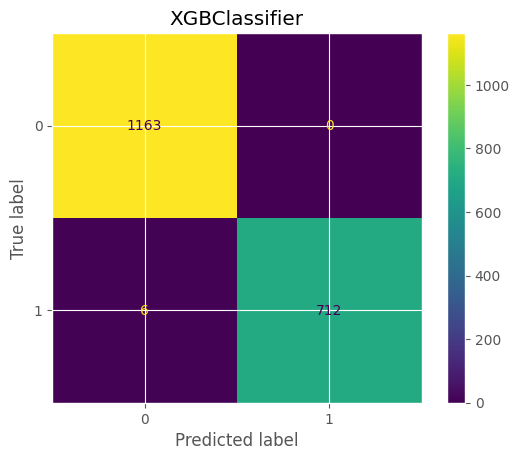

In [30]:
cm_disp.plot()
plt.title(f"{best_model.__class__.__name__}")
plt.savefig("confusion_matrix.png")
plt.show()

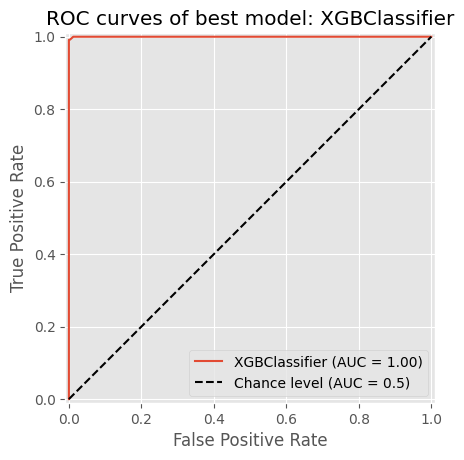

In [31]:
y_prob = best_model.predict_proba(X_test)[:, 1]
roc_disp = RocCurveDisplay.from_predictions(
    y_test,
    y_prob,
    plot_chance_level=True,
    name=best_model.__class__.__name__
)
roc_disp.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curves of best model: {best_model.__class__.__name__}",
)
plt.savefig("roc.png")
plt.show()

In [32]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [33]:
approximate_permutation_importance[-5:]

[('habitat', 0.0),
 ('gill-size', 0.002954024047017401),
 ('odor', 0.01585364219607873),
 ('stalk-shape', 0.027859015365711913),
 ('spore-print-color', 0.14613518703683565)]

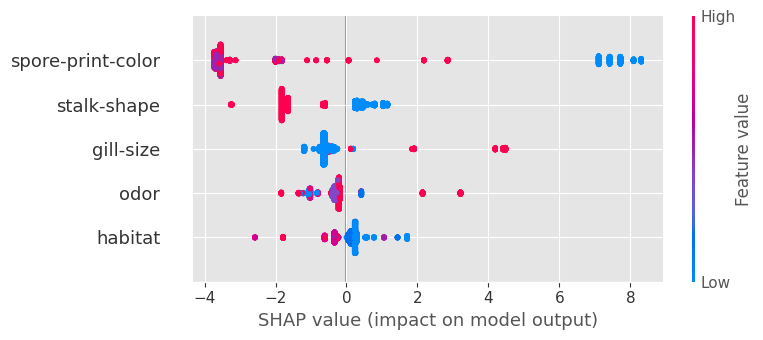

In [34]:
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shape_summary.png")
plt.show()

#### force plot of test example (poisonous)

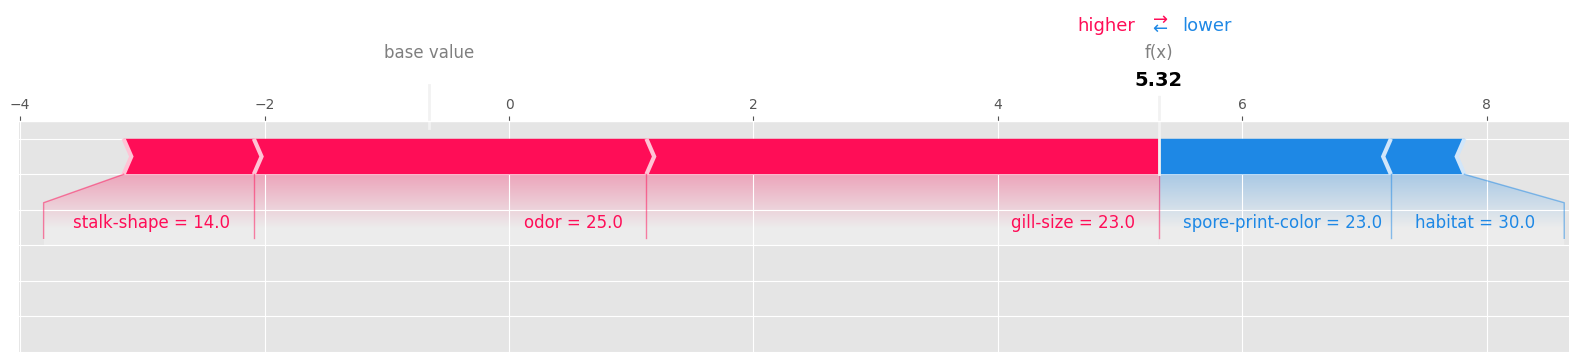

In [35]:
shap.plots.force(explainer.expected_value, shap_values[y_test == 1][0, :], X_test[y_test == 1].iloc[0, :], matplotlib=True, show=False)
plt.savefig("shap_force_poisonous.png")
plt.show()

#### force plot of test example (edible)

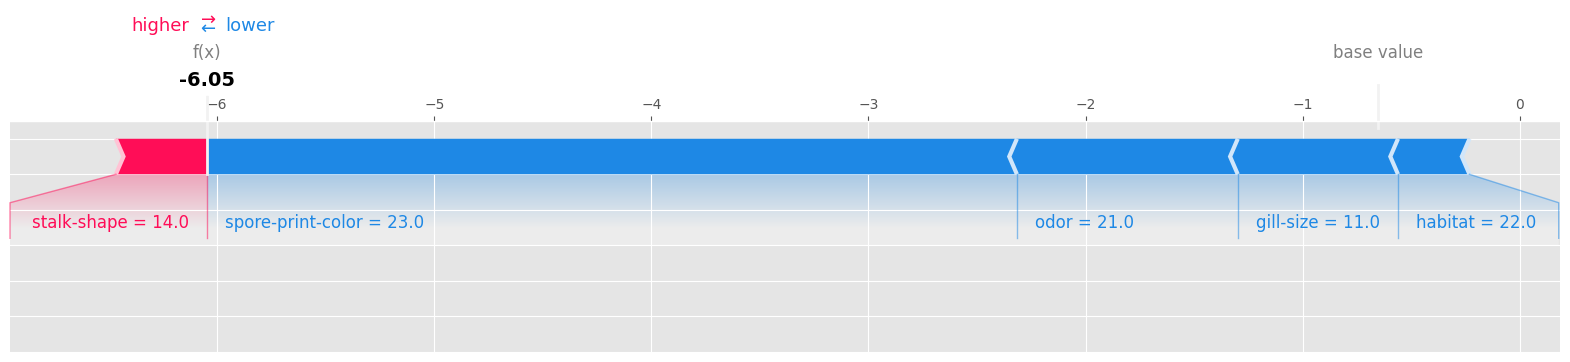

In [36]:
shap.plots.force(explainer.expected_value, shap_values[y_test == 0][0, :], X_test[y_test == 0].iloc[0, :], matplotlib=True, show=False)
plt.savefig("shap_force_edible.png")
plt.show()

#### decision plot (poisonous)

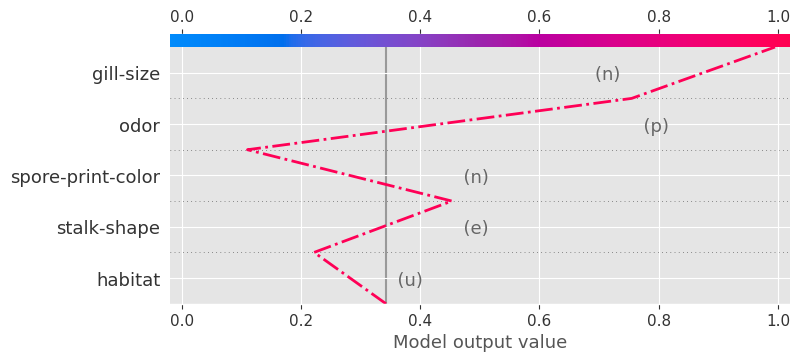

In [40]:
shap.decision_plot(
    explainer.expected_value,
    shap_values[y_test == 1][0, :],
    X_test[y_test == 1].iloc[0, :].replace(dict(enumerate(charset))),
    link="logit",
    highlight=0,
    show=False
)
plt.savefig("shape_decision_poisonous.png")
plt.show()

#### producing final model
- repeat the model fitting procedure carried out during model evaluation stage (including hyperparameter search) on entire dataset
- train final model with best param on entire dataset

In [38]:
final_gs = gs.fit(features_1.select(approximate_top_features).to_numpy(), label.to_numpy())

In [39]:
final_model = XGBClassifier(**final_gs.best_params_)
final_model.fit(features_1.select(approximate_top_features).to_numpy(), label.to_numpy())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)